In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Input
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
%tensorflow_version 2.x
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.15.0
/device:GPU:0
Num GPUs Available:  1


In [ ]:
%cd /content/drive/"My Drive"/"Covid-dataset"

/content/drive/My Drive/Covid-dataset


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/drive/MyDrive/Covid-dataset"
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset
!unzip \*.zip  && rm *.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /drive/MyDrive/Covid-dataset. Or use the environment method.
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/drive/MyDrive/Covid-dataset'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [ ]:
train

,File,DiseaseID,Disease Type
0,COVID/Covid (126).png,0,COVID
1,COVID/Covid (256).png,0,COVID
2,COVID/Covid (20).png,0,COVID
3,COVID/Covid (170).png,0,COVID
4,COVID/Covid (227).png,0,COVID
...,...,...,...
2485,non-COVID/Non-Covid (1165).png,1,non-COVID
2486,non-COVID/Non-Covid (1179).png,1,non-COVID
2487,non-COVID/Non-Covid (1225).png,1,non-COVID
2488,non-COVID/Non-Covid (205).png,1,non-COVID


In [ ]:
#Read and resize images

IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)


2490it [13:10,  3.15it/s]

(2490, 64, 64, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state = 42)

## Using ResNET model architecture

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
SIZE=64
N_ch=3

In [ ]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    # Define input layer
    input = Input(shape=(SIZE, SIZE, N_ch))

    # Pass input through ResNet50 model
    x = resnet50(input)

    # Global average pooling
    x = GlobalAveragePooling2D()(x)

    # Batch normalization and dropout
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Additional dense layer
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer
    output = Dense(2, activation='softmax', name='root')(x)

    # Define the model
    model = Model(input, output)

    # Compile the model with Adam optimizer
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Print model summary
    model.summary()

    return model


In [ ]:
# Train the model
model = build_resnet50()

# Assuming `build_resnet50()` is a function that builds a ResNet50 model
model = build_resnet50()

# Setting up callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('ResNet50_Model.hdf5', verbose=1, save_best_only=True)

# Setting up data augmentation
datagen = ImageDataGenerator(rotation_range=360,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)

# Fitting the data generator to your training data
datagen.fit(X_train)  # Assuming X_train contains your training data

94765736/94765736 [==============================] - 0s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                           

In [ ]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))


Epoch 1/100


<ipython-input-17-427914eb0244>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


31/31 [==============================] - ETA: 0s - loss: 1.2354 - accuracy: 0.5171
Epoch 1: val_loss improved from inf to 1.24327, saving model to ResNet50_Model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 56s 508ms/step - loss: 1.2354 - accuracy: 0.5171 - val_loss: 1.2433 - val_accuracy: 0.4880 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 1.1744 - accuracy: 0.5202
Epoch 2: val_loss did not improve from 1.24327
31/31 [==============================] - 4s 137ms/step - loss: 1.1744 - accuracy: 0.5202 - val_loss: 5.2192 - val_accuracy: 0.4880 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 1.0465 - accuracy: 0.5633
Epoch 3: val_loss did not improve from 1.24327
31/31 [==============================] - 5s 146ms/step - loss: 1.0465 - accuracy: 0.5633 - val_loss: 7.3403 - val_accuracy: 0.4880 - lr: 0.0010
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 0.9293 - accuracy: 0.6027
Epoch 4: val_loss did not improve from 1.24327
31/31 [==============================] - 4s 131ms/step - loss: 0.9293 - accuracy: 0.6027 - val_loss: 12.9453 - val_accuracy: 0.4880 - lr: 0.0

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

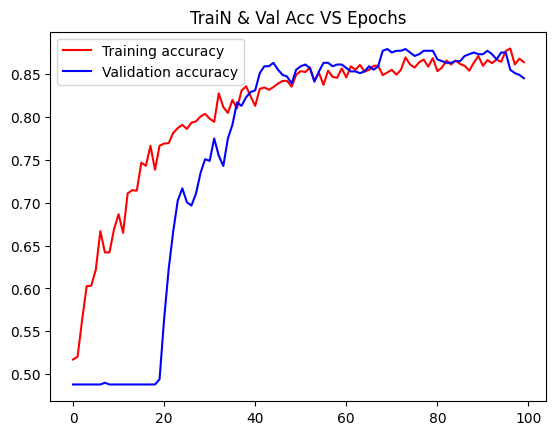

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()


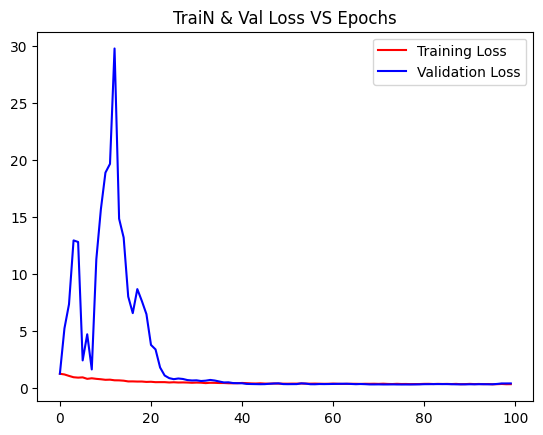

<Figure size 640x480 with 0 Axes>

In [ ]:

epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
model.load_weights("ResNet50_Model.hdf5")
score = model.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

16/16 [==============================] - 0s 21ms/step - loss: 0.2942 - accuracy: 0.8735
Test Loss: 0.2941526770591736
Test accuracy: 87.34939694404602


16/16 [==============================] - 2s 21ms/step


Text(0.5, 1.0, 'Confusion Matrix')

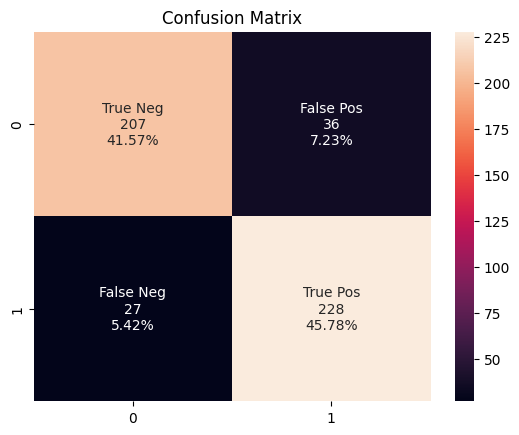

In [ ]:
Y_pred = model.predict(X_val)
Y_predx = np.argmax(Y_pred, axis = -1)
Y_valx = np.argmax(Y_val, axis = -1)
cf_matrix = confusion_matrix(Y_valx, Y_predx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")


In [ ]:
from sklearn.metrics import classification_report

target_names = ['COVID', 'non-COVID']

cf_matrix = confusion_matrix(Y_valx, Y_predx)

print(classification_report(Y_valx, Y_predx, target_names=target_names))

              precision    recall  f1-score   support

       COVID       0.88      0.85      0.87       243
   non-COVID       0.86      0.89      0.88       255

    accuracy                           0.87       498
   macro avg       0.87      0.87      0.87       498
weighted avg       0.87      0.87      0.87       498

